<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/lensing/notebooks/Denise_lightcone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
import tensorflow as tf
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import cosmo,z2a,a2z,afactor, chifactor,rad_comoving_distance
from flowpm.raytracing import  lightcone, Born, wlen, cons, A, nbar_
import flowpm.constants as constants
import flowpm  
import time
start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# You may need to adapt this path depending on where you are running the notebook
#This is the power spectrum of initial conditions
klin = np.loadtxt('/Users/dl264294/Desktop/github/flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin=linear_matter_power(cosmo, klin)
ipklin = iuspline(klin, plin)

In [3]:
nc=[128,128,1280]   # size of the cube, number of cells
nc_xy=nc[0]                     # number of cell for x and  y 
Boxsize=[200,200,2000]          # Physical size of the cube

In [4]:
#To make lens planes of size 200 Mpc/h :
r = np.linspace(0,2000,10, endpoint=True)
a = afactor(r)  

Text(0.5, 0, 'Mpc/h')

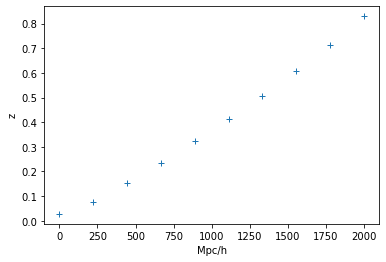

In [5]:
# This allows us to go to roughly z=1
plot(r,a2z(a), '+')
ylabel(r'z')
xlabel(r'Mpc/h')

In [6]:
# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = np.linspace(0.1, a[-1], 4, endpoint=True)
initial_conditions = flowpm.linear_field(nc,    
                                        Boxsize, 
                                         ipklin,         
                                         batch_size=1)
# Sample particles
state = flowpm.lpt_init(initial_conditions, 0.1)   
# Evolve particles down to z=0
med_state = flowpm.nbody(state, init_stages, nc)         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])

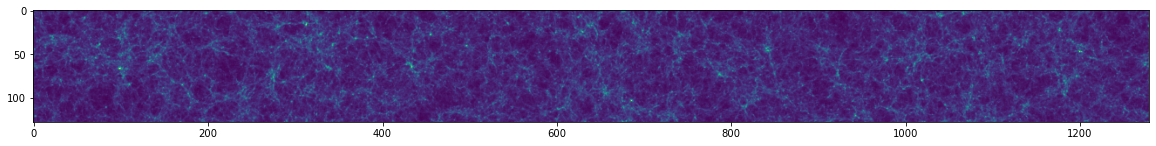

In [7]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, nc).numpy().sum(axis=0))

In [8]:
#Let's define the source's redshift
zs=0.7755102040816326
a_s=z2a(zs)
ds=chifactor(a_s)

In [9]:
final_state, lps_a, lps = lightcone(med_state, a[::-1], 
                                  nc, 
                                    5.*60/nc_xy, nc_xy)


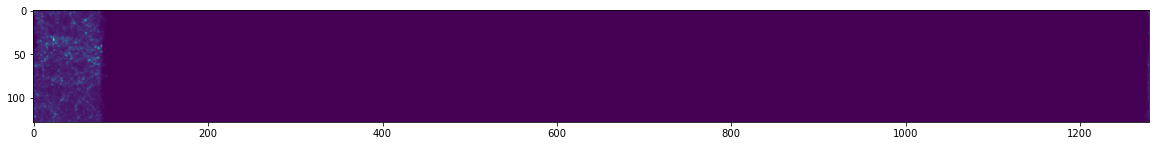

In [10]:
#Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [nc_xy,nc_xy,-1]).numpy().sum(axis=0)) 

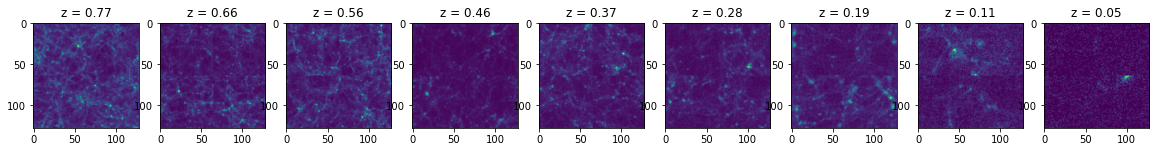

In [11]:
# Here are the lens planes exported during the simulation
figure(figsize=(20,5))
for i in range(len(lps_a)):
    subplot(1,9,i+1)
    imshow(lps[i][0]);
    title('z = %0.2f'%a2z(lps_a[i]))


In [12]:
final_state.shape   # tensor of shape (3, batch_size, npart, 3)

TensorShape([3, 1, 1196032, 3])

In [17]:
k_map=Born(lps_a,lps,ds,nc,Boxsize,nc_xy)

In [14]:
# k_map=0
# for i in range(len(lps_a)):
#         k_map += cons(cosmo)*lps[i][0]*  wlen(ds,lps_a[i])

In [32]:
from astropy.io import fits
hdu = fits.PrimaryHDU(k_map)
hdul = fits.HDUList([hdu])
hdul.writeto('kmap.fits')

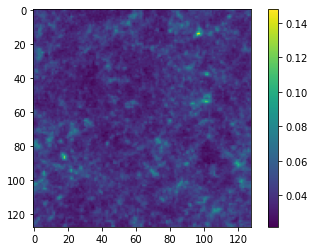

In [39]:
imshow(k_map)
colorbar()
savefig('kmap_denise.png',dpi=100)


In [19]:
#begin the computation of power spectrum from the map

In [20]:
def radial_profile(data):
    """
    Compute the radial profile of 2d image
    :param data: 2d image
    :return: radial profile
    """
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype('int32')

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def measure_power_spectrum(map_data, pixel_size):
    """
    measures power 2d data
    :param map_data: map (n x n)
    :param pixel_size: pixel size (rad/pixel)
    :return: ell
    :return: power spectrum
    """
    data_ft = np.fft.fftshift(np.fft.fft2(map_data)) / map_data.shape[0]
    nyquist = np.int(map_data.shape[0]/2)
    power_spectrum = radial_profile(np.real(data_ft*np.conj(data_ft)))[:nyquist]
    power_spectrum = power_spectrum*pixel_size**2

    k = np.arange(power_spectrum.shape[0])
    ell = 2. * np.pi * k / pixel_size / map_data.shape[0]


    return ell, power_spectrum

In [21]:
resolution = 5.*60/nc_xy # What pixel resolution do we need to cover the 5 tansverse degrees with 128 pixel images
#pixel_size = np.pi * resolution / 180. / 60. #rad/pixel
pixel_size=5./nc_xy / 180 *np.pi
#ell = 2. * np.pi * k / pixel_size / 512
ell, ps_example = measure_power_spectrum(k_map, pixel_size)

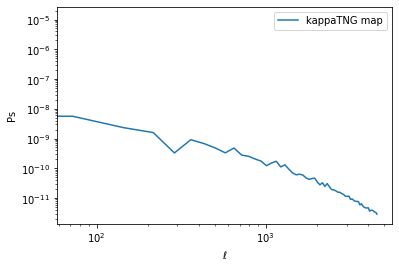

In [22]:
loglog(ell, ps_example, label='kappaTNG map')
xlabel('$\ell$')
ylabel('Ps')
legend()

In [23]:
#begin computation power spectra from theory 

In [24]:
import jax
import jax_cosmo as jc

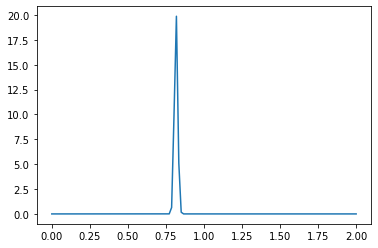

In [25]:
z = linspace(0,2)
pz = zeros_like(z)
pz[20] =1 
nzs_s=jc.redshift.kde_nz(z, pz,bw=0.011)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))

In [26]:
nzs = [nzs_s]

In [27]:
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

In [28]:
elle = np.logspace(1,4) # Defines a range of \ell
cosmo_jc = jc.Planck15()
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jc, elle, probes)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Populating the interactive namespace from numpy and matplotlib


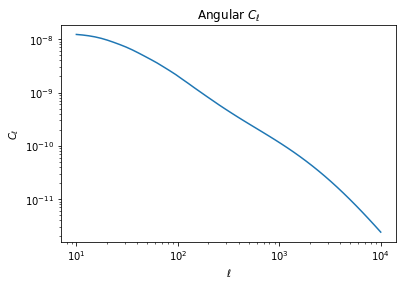

In [29]:

%pylab inline 
loglog(elle, cls[0])
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');

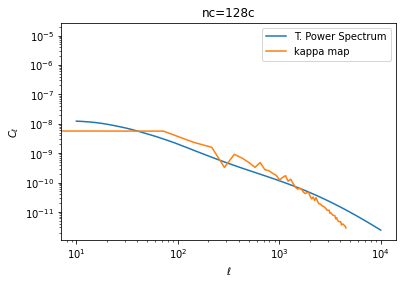

In [38]:
loglog(elle, cls[0],label='T. Power Spectrum')
loglog(ell, ps_example, label='kappa map')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
#xlim(10,10000)
legend()
title('nc=128c')
savefig('power_con128.png',dpi=80)

In [31]:
print("--- %d seconds ---(%d minutes)" % ((time.time() - start_time),(time.time() - start_time)/60.))

--- 760 seconds ---(12 minutes)
